In [6]:
import networkx as nx
from itertools import product
from typing import List, Tuple, Dict
import json

In [48]:
import sympy as sp

In [49]:
def get_derivative_function(expression_str, variable='x'):    
    # Step 2: Define the variable and parse the expression
    x = sp.symbols(variable)
    expression = sp.sympify(expression_str)
    
    # Step 3: Differentiate the expression with respect to x
    derivative_expr = sp.diff(expression, x)
    
    # Step 4: Convert the derivative expression to a Python function
    derivative_func = sp.lambdify(x, derivative_expr, 'numpy')
    
    # Optional: Print derivative expression for verification
    print(f"Original expression: {expression}")
    print(f"Derivative: {derivative_expr}")
    
    return derivative_func

In [52]:
get_derivative_function('x**2 + 2*x')(2)

Original expression: x**2 + 2*x
Derivative: 2*x + 2


6

In [7]:
def simulate_atomic(G: nx.DiGraph, source_sink_pairs: List[Tuple[int, int]], demands: List[int], latency_functions: Dict):
    # index represents a player (ex: index 0 = player 0, etc)
    # value represents a list of paths the player can take from its source to its sink
    paths = []

    # initialize paths array
    for idx, val in enumerate(source_sink_pairs):
        s = source_sink_pairs[idx][0]
        t = source_sink_pairs[idx][1]
        simple_paths = list(nx.all_simple_paths(G, s, t))
        print(simple_paths)
        paths.append(simple_paths)

    # flow: index represents a player (player 0 = source_sink_pair[0], etc)
    # value represents an path index for that player
    min_total_latency = float('inf')
    best_flow = None # best flow is the one that minimizes total latency

    # map a flow tuple to a map detailing the latency each player suffers in the flow
    # key: flow tuple, value: map of player : player_latency
    equil_lookup = {}

    # list of all flow tuples (need tuples for map lookup)
    # TODO: calculate product(...) and store in all_flows directly, rather than building all_flows one by one
    all_flows = []
    
    for flow in product(*[[i for i in range(len(path))] for idx, path in enumerate(paths)]):
        total_latency = 0
        flow_tuple = tuple(flow)
        all_flows.append(flow_tuple)
        f_e = {} # store the amount of traffic that uses any given edge in this flow

        print('*' * 8, flow, '*' * 8)

        # calculate how much flow each edge has, store in f_e
        for player, path_idx in enumerate(flow):
            path = paths[player][path_idx]
            print('player {}: path {}'.format(player, paths[player][path_idx]))
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                if edge in f_e:
                    f_e[edge] += demands[player]
                else:
                    f_e[edge] = demands[player]
        print(f_e)

        # calculate the sum of each player's latency in this flow
        for player, path_idx in enumerate(flow):
            path = paths[player][path_idx]
            player_latency = 0
            # print('player {}: path {}'.format(player, paths[player][path_idx]))
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                edge_latency = latency_functions[edge](f_e[edge])
                total_latency += edge_latency
                player_latency += edge_latency
            if flow_tuple not in equil_lookup:
                equil_lookup[flow_tuple] = {player : player_latency}
            else:
                equil_lookup[flow_tuple][player] = player_latency
                
        print(total_latency)

        # update optimal flow if it exists
        if total_latency <= min_total_latency:
            min_total_latency = total_latency
            best_flow = flow


    # store list of equil flows, each of which is represented by a tuple
    equil_flows = []
    
    # iterate through each flow, check if each one is an equilibrium flow
    for flow in all_flows:
        is_equil = True
        for player in range(len(flow)):
            curr_latency = equil_lookup[flow][player]
            for path_idx in range(len(paths[player])):
                flow_list = list(flow)
                flow_list[player] = path_idx
                new_flow = tuple(flow_list)
                if new_flow in equil_lookup:
                    # could've done better by deviating
                    if equil_lookup[new_flow][player] < curr_latency: 
                        is_equil = False
                        break
        if is_equil:
            print('FOUND EQUILIBIRUM FLOW', flow)
            equil_flows.append(flow)
    
    print('*' * 30)
    # print out the best path for each player
    for player, path_idx in enumerate(best_flow):
        print('player {}: path {}'.format(player, paths[player][path_idx]))
    return paths, equil_flows, best_flow, min_total_latency


In [41]:
import networkx as nx
from typing import List, Tuple, Dict
import random

def simulate_atomic_best_response(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000
):
    # index represents a player (e.g., index 0 = player 0)
    # value represents a list of paths the player can take from their source to their sink
    paths = []

    # Initialize paths array for each player
    for idx, (s, t) in enumerate(source_sink_pairs):
        simple_paths = list(nx.all_simple_paths(G, s, t))
        paths.append(simple_paths)

    # Initialize current_flow: list where index represents a player,
    # value is the path index currently chosen by the player
    current_flow = []
    for player_paths in paths:
        # Initialize with a random path or the first available path
        current_flow.append(0)  # or random.randint(0, len(player_paths) - 1)

    # Initialize variables to track convergence
    converged = False
    iteration = 0

    # Loop until convergence or maximum iterations reached
    while not converged and iteration < max_iterations:
        converged = True  # Assume convergence unless a player changes strategy
        iteration += 1

        # Compute current edge flows
        f_e = {}  # Edge flows
        for player_idx, path_idx in enumerate(current_flow):
            path = paths[player_idx][path_idx]
            demand = demands[player_idx]
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                f_e[edge] = f_e.get(edge, 0) + demand

        # For each player, check if they can improve their latency by switching paths
        for player_idx in range(len(current_flow)):
            current_path_idx = current_flow[player_idx]
            current_path = paths[player_idx][current_path_idx]
            current_latency = 0

            # Compute current latency for this player
            for i in range(len(current_path) - 1):
                edge = (current_path[i], current_path[i + 1])
                flow = f_e[edge]
                edge_latency = latency_functions[edge](flow)
                current_latency += edge_latency

            # Find the best response for this player
            best_path_idx = current_path_idx
            best_latency = current_latency

            # Check all possible paths for this player
            for alternative_path_idx, alternative_path in enumerate(paths[player_idx]):
                if alternative_path_idx == current_path_idx:
                    continue  # Skip current path

                # Compute hypothetical edge flows if the player switches to alternative path
                hypothetical_f_e = f_e.copy()
                demand = demands[player_idx]

                # Remove player's demand from current path edges
                for i in range(len(current_path) - 1):
                    edge = (current_path[i], current_path[i + 1])
                    hypothetical_f_e[edge] -= demand

                # Add player's demand to alternative path edges
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

                # Compute latency for the alternative path
                alternative_latency = 0
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    flow = hypothetical_f_e[edge]
                    edge_latency = latency_functions[edge](flow)
                    alternative_latency += edge_latency

                # If the alternative latency is better, update best response
                if alternative_latency < best_latency:
                    best_latency = alternative_latency
                    print('old, new', current_path_idx, best_path_idx)
                    best_path_idx = alternative_path_idx

            # If the best path is different from current, update player's path and set converged to False
            if best_path_idx != current_flow[player_idx]:
                current_flow[player_idx] = best_path_idx
                converged = False
                break # found a player who can do better, update that player and try BRD again!

    if iteration >= max_iterations:
        print('reached max iterations')
    # After convergence or reaching max iterations, compute total latency
    total_latency = 0
    f_e = {}  # Edge flows
    for player_idx, path_idx in enumerate(current_flow):
        path = paths[player_idx][path_idx]
        demand = demands[player_idx]
        player_latency = 0
        for i in range(len(path) - 1):
            edge = (path[i], path[i + 1])
            f_e[edge] = f_e.get(edge, 0) + demand
            flow = f_e[edge]
            edge_latency = latency_functions[edge](flow)
            player_latency += edge_latency
        total_latency += player_latency

    # Prepare the equilibrium flow as a tuple of path indices
    equil_flow = tuple(current_flow)

    return paths, equil_flow, total_latency

In [53]:
import networkx as nx
from typing import List, Tuple, Dict
import random

def simulate_atomic_best_response_with_taxes(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000
):
    # index represents a player (e.g., index 0 = player 0)
    # value represents a list of paths the player can take from their source to their sink
    paths = []

    # Initialize paths array for each player
    for idx, (s, t) in enumerate(source_sink_pairs):
        simple_paths = list(nx.all_simple_paths(G, s, t))
        paths.append(simple_paths)

    # Initialize current_flow: list where index represents a player,
    # value is the path index currently cbhosen by the player
    current_flow = []
    for player_paths in paths:
        # Initialize with a random path or the first available path
        current_flow.append(0)  # or random.randint(0, len(player_paths) - 1)

    # Initialize variables to track convergence
    converged = False
    iteration = 0

    # Loop until convergence or maximum iterations reached
    while not converged and iteration < max_iterations:
        converged = True  # Assume convergence unless a player changes strategy
        iteration += 1

        # Compute current edge flows
        f_e = {}  # Edge flows
        for player_idx, path_idx in enumerate(current_flow):
            path = paths[player_idx][path_idx]
            demand = demands[player_idx]
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                f_e[edge] = f_e.get(edge, 0) + demand

        # For each player, check if they can improve their latency by switching paths
        for player_idx in range(len(current_flow)):
            current_path_idx = current_flow[player_idx]
            current_path = paths[player_idx][current_path_idx]
            current_latency = 0

            # Compute current latency for this player with marginal cost taxes
            for i in range(len(current_path) - 1):
                edge = (current_path[i], current_path[i + 1])
                flow = f_e[edge]
                f1, f2 = latency_functions[edge]
                edge_latency = f1(flow) + flow * f2(flow)
                current_latency += edge_latency

            # Find the best response for this player
            best_path_idx = current_path_idx
            best_latency = current_latency

            # Check all possible paths for this player
            for alternative_path_idx, alternative_path in enumerate(paths[player_idx]):
                if alternative_path_idx == current_path_idx:
                    continue  # Skip current path

                # Compute hypothetical edge flows if the player switches to alternative path
                hypothetical_f_e = f_e.copy()
                demand = demands[player_idx]

                # Remove player's demand from current path edges
                for i in range(len(current_path) - 1):
                    edge = (current_path[i], current_path[i + 1])
                    hypothetical_f_e[edge] -= demand

                # Add player's demand to alternative path edges
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

                # Compute latency for the alternative path with marginal cost taxes
                alternative_latency = 0
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    flow = hypothetical_f_e[edge]
                    f1, f2 = latency_functions[edge]
                    edge_latency = f1(flow) + flow * f2(flow)
                    alternative_latency += edge_latency

                # If the alternative latency is better, update best response
                if alternative_latency < best_latency:
                    best_latency = alternative_latency
                    best_path_idx = alternative_path_idx

            # If the best path is different from current, update player's path and set converged to False
            if best_path_idx != current_flow[player_idx]:
                current_flow[player_idx] = best_path_idx
                converged = False
                break

    # After convergence or reaching max iterations, compute total latency
    total_latency = 0
    f_e = {}  # Edge flows
    for player_idx, path_idx in enumerate(current_flow):
        path = paths[player_idx][path_idx]
        demand = demands[player_idx]
        player_latency = 0
        for i in range(len(path) - 1):
            edge = (path[i], path[i + 1])
            f_e[edge] = f_e.get(edge, 0) + demand

    # Calculate the actual total latency without taxes
    total_latency = 0
    for player_idx, path_idx in enumerate(current_flow):
        path = paths[player_idx][path_idx]
        player_latency = 0
        for i in range(len(path) - 1):
            edge = (path[i], path[i + 1])
            flow = f_e[edge]
            f1, _ = latency_functions[edge]
            edge_latency = f1(flow)
            player_latency += edge_latency
        total_latency += player_latency

    # Prepare the equilibrium flow as a tuple of path indices
    equil_flow = tuple(current_flow)

    return paths, equil_flow, total_latency


In [1]:
def simulate_atomic_best_response_with_sensitivities(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict[Tuple[Tuple[int, int], int], Tuple[callable, callable]],
    sensitivities: List[float],
    max_iterations: int = 1000
):
    # index represents a player (e.g., index 0 = player 0)
    # value represents a list of paths the player can take from their source to their sink
    paths = []

    num_players = len(source_sink_pairs)

    # Initialize paths array for each player
    for idx, (s, t) in enumerate(source_sink_pairs):
        simple_paths = list(nx.all_simple_paths(G, s, t))
        if not simple_paths:
            raise ValueError(f"No paths found from node {s} to node {t} for player {idx}")
        paths.append(simple_paths)

    # Initialize current_flow: list where index represents a player,
    # value is the path index currently chosen by the player
    current_flow = []
    for player_paths in paths:
        # Initialize with a random path or the first available path
        current_flow.append(0)  # or random.randint(0, len(player_paths) - 1)

    # Initialize variables to track convergence
    converged = False
    iteration = 0

    # Loop until convergence or maximum iterations reached
    while not converged and iteration < max_iterations:
        converged = True  # Assume convergence unless a player changes strategy
        iteration += 1

        # Compute current edge flows
        f_e = {}  # Edge flows
        for player_idx, path_idx in enumerate(current_flow):
            path = paths[player_idx][path_idx]
            demand = demands[player_idx]
            for i in range(len(path) - 1):
                edge = (path[i], path[i + 1])
                f_e[edge] = f_e.get(edge, 0) + demand

        # For each player, check if they can improve their cost by switching paths
        for player_idx in range(num_players):
            current_path_idx = current_flow[player_idx]
            current_path = paths[player_idx][current_path_idx]
            s_i = sensitivities[player_idx]
            demand = demands[player_idx]
            current_cost = 0

            # Compute current cost for this player with sensitivity to taxes
            for i in range(len(current_path) - 1):
                edge = (current_path[i], current_path[i + 1])
                flow = f_e[edge]
                f1, f2 = latency_functions[(edge, player_idx)]
                latency = f1(flow)
                tax = flow * f2(flow)
                edge_cost = latency + s_i * tax
                current_cost += edge_cost

            # Find the best response for this player
            best_path_idx = current_path_idx
            best_cost = current_cost

            # Check all possible paths for this player
            for alternative_path_idx, alternative_path in enumerate(paths[player_idx]):
                if alternative_path_idx == current_path_idx:
                    continue  # Skip current path

                # Compute hypothetical edge flows if the player switches to alternative path
                hypothetical_f_e = f_e.copy()

                # Remove player's demand from current path edges
                for i in range(len(current_path) - 1):
                    edge = (current_path[i], current_path[i + 1])
                    hypothetical_f_e[edge] -= demand

                # Add player's demand to alternative path edges
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

                # Compute cost for the alternative path with sensitivity to taxes
                alternative_cost = 0
                for i in range(len(alternative_path) - 1):
                    edge = (alternative_path[i], alternative_path[i + 1])
                    flow = hypothetical_f_e[edge]
                    f1, f2 = latency_functions[(edge, player_idx)]
                    latency = f1(flow)
                    tax = flow * f2(flow)
                    edge_cost = latency + s_i * tax
                    alternative_cost += edge_cost

                # If the alternative cost is better, update best response
                if alternative_cost < best_cost:
                    best_cost = alternative_cost
                    best_path_idx = alternative_path_idx

            # If the best path is different from current, update player's path and set converged to False
            if best_path_idx != current_flow[player_idx]:
                current_flow[player_idx] = best_path_idx
                converged = False

    # After convergence or reaching max iterations, compute total latency (without taxes)
    total_latency = 0
    f_e = {}  # Edge flows
    for player_idx, path_idx in enumerate(current_flow):
        path = paths[player_idx][path_idx]
        demand = demands[player_idx]
        for i in range(len(path) - 1):
            edge = (path[i], path[i + 1])
            f_e[edge] = f_e.get(edge, 0) + demand

    # Calculate the actual total latency without taxes
    total_latency = 0
    for player_idx, path_idx in enumerate(current_flow):
        path = paths[player_idx][path_idx]
        player_latency = 0
        for i in range(len(path) - 1):
            edge = (path[i], path[i + 1])
            flow = f_e[edge]
            f1, _ = latency_functions[(edge, player_idx)]
            edge_latency = f1(flow)
            player_latency += edge_latency
        total_latency += player_latency

    # Prepare the equilibrium flow as a tuple of path indices
    equil_flow = tuple(current_flow)

    return paths, equil_flow, total_latency

NameError: name 'nx' is not defined

In [56]:
def json_to_atomic_instance(graph_json):
    if isinstance(graph_json, str):
        with open(graph_json) as f:
            graph = json.load(f)
    elif not isinstance(graph_json, dict):
        raise Exception('Invalid graph json type. Either requires string of a filename or a json object')
    id_to_label = {}
    for node in graph['nodes']:
        print(node)
        id_to_label[node['id']] = node['label']
    G = nx.DiGraph()
    latency_functions = {}
    for edge in graph['edges']:
        from_node = id_to_label[edge['from']]
        to_node = id_to_label[edge['to']]
        G.add_edge(from_node, to_node)

        f1 = eval('lambda x: ' + edge['latencyFunction'])
        # f2 = get_derivative_function(edge['latencyFunction'], variable='x')
        latency_functions[(from_node, to_node)] = f1
    source_sink_pairs = []
    demands = []
    for source_sink_pair in graph['sourceSinkPairs']:
        source_node = id_to_label[source_sink_pair['source']]
        sink_node = id_to_label[source_sink_pair['sink']]
        demand = int(source_sink_pair['demand'])
        source_sink_pairs.append((source_node, sink_node))
        demands.append(demand)
        
    nx.draw_networkx(G)
    print(latency_functions)
    return (G, source_sink_pairs, demands, latency_functions)

In [55]:
def json_to_atomic_instance_2(graph_json):
    if isinstance(graph_json, str):
        with open(graph_json) as f:
            graph = json.load(f)
    elif not isinstance(graph_json, dict):
        raise Exception('Invalid graph json type. Either requires string of a filename or a json object')
    id_to_label = {}
    for node in graph['nodes']:
        print(node)
        id_to_label[node['id']] = node['label']
    G = nx.DiGraph()
    latency_functions = {}
    for edge in graph['edges']:
        from_node = id_to_label[edge['from']]
        to_node = id_to_label[edge['to']]
        G.add_edge(from_node, to_node)

        f1 = eval('lambda x: ' + edge['latencyFunction'])
        f2 = get_derivative_function(edge['latencyFunction'], variable='x')
        latency_functions[(from_node, to_node)] = (f1, f2)
    source_sink_pairs = []
    demands = []
    for source_sink_pair in graph['sourceSinkPairs']:
        source_node = id_to_label[source_sink_pair['source']]
        sink_node = id_to_label[source_sink_pair['sink']]
        demand = int(source_sink_pair['demand'])
        source_sink_pairs.append((source_node, sink_node))
        demands.append(demand)
        
    nx.draw_networkx(G)
    print(latency_functions)
    return (G, source_sink_pairs, demands, latency_functions)

In [57]:
def graph_example():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph.txt')
    paths, equil_flows, best_flow, min_total_latency = simulate_atomic(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Optimal flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

In [42]:
def graph_example_2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph.txt')
    paths, equil_flows, min_total_latency = simulate_atomic_best_response(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Minimum total latency: ', min_total_latency)

{'id': '2cf6c294-91dc-41ad-97b3-22f5a30b821e', 'x': -98, 'y': 191.125, 'label': 'v'}
{'id': '4e4c47cf-7af3-4d74-9cec-e9a95e836934', 'x': -366.196533203125, 'y': 58.125, 'label': 'w'}
{'id': '57bd2c0a-4459-4ad0-89c9-db30f0491d75', 'x': -364.777587890625, 'y': 283.625, 'label': 's'}
{'id': '77894c0c-ca41-4705-b595-a97002dccacd', 'x': -609.1549787359636, 'y': 170.73738821090166, 'label': 't'}
{('s', 'v'): <function <lambda> at 0x10a602700>, ('v', 't'): <function <lambda> at 0x1083d88b0>, ('s', 't'): <function <lambda> at 0x10c405820>, ('s', 'w'): <function <lambda> at 0x10c405160>, ('w', 't'): <function <lambda> at 0x10c405790>, ('v', 'w'): <function <lambda> at 0x10c405670>}
[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]
[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]
******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 3, ('v', 't'): 3}
160
******** (0, 1) ********
player 0: path ['s', 'v', 't']
pl

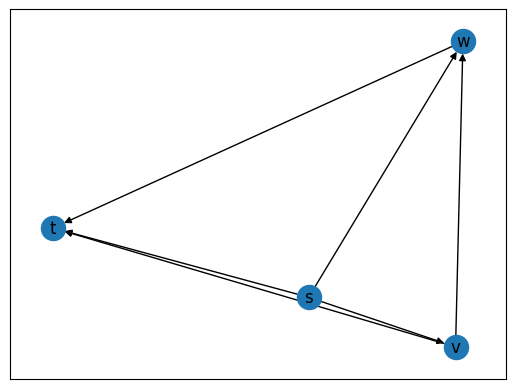

In [58]:
graph_example()

{'id': '2cf6c294-91dc-41ad-97b3-22f5a30b821e', 'x': -98, 'y': 191.125, 'label': 'v'}
{'id': '4e4c47cf-7af3-4d74-9cec-e9a95e836934', 'x': -366.196533203125, 'y': 58.125, 'label': 'w'}
{'id': '57bd2c0a-4459-4ad0-89c9-db30f0491d75', 'x': -364.777587890625, 'y': 283.625, 'label': 's'}
{'id': '77894c0c-ca41-4705-b595-a97002dccacd', 'x': -609.1549787359636, 'y': 170.73738821090166, 'label': 't'}
{('s', 'v'): <function <lambda> at 0x10a7b21f0>, ('v', 't'): <function <lambda> at 0x10a577d30>, ('s', 't'): <function <lambda> at 0x10a577790>, ('s', 'w'): <function <lambda> at 0x10a7fcf70>, ('w', 't'): <function <lambda> at 0x10a7fcaf0>, ('v', 'w'): <function <lambda> at 0x10a77fa60>}
old, new 0 0
old, new 0 0
old, new 1 1
old, new 3 3
old, new 2 2
old, new 0 0
old, new 1 1
old, new 3 3
old, new 2 2
old, new 0 0
old, new 1 1
old, new 3 3
old, new 2 2
old, new 0 0
old, new 1 1
old, new 3 3
old, new 2 2
old, new 0 0
old, new 1 1
old, new 3 3
old, new 2 2
old, new 0 0
old, new 1 1
old, new 3 3
old, n

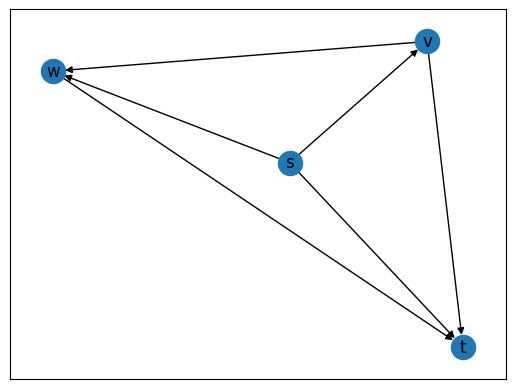

In [43]:
graph_example_2()

In [12]:
def braess_before():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_before.txt')
    paths, equil_flows, best_flow, min_total_latency = simulate_atomic(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Optimal flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

In [31]:
def braess_before_2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_before.txt')
    paths, equil_flows, min_total_latency = simulate_atomic_best_response(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Minimum total latency: ', min_total_latency)

{'id': '9c0fb1f3-5ead-4efb-81fe-4e010315be27', 'x': -415, 'y': 37.125, 'label': 's'}
{'id': 'c5099898-39d5-4178-a488-6dcdda311088', 'x': -150, 'y': 54.125, 'label': 't'}
{'id': '1456ceaa-39da-421d-9eef-ebd1c0975100', 'x': -257.277587890625, 'y': -58.375, 'label': 'v'}
{'id': 'e365c756-905d-42b6-ad8a-f038f89de2aa', 'x': -9.11470281018785, 'y': 117.9947018257335, 'label': 'w'}
{('s', 'v'): <function <lambda> at 0x108358dc0>, ('v', 't'): <function <lambda> at 0x10a577ca0>, ('s', 'w'): <function <lambda> at 0x10a577820>, ('w', 't'): <function <lambda> at 0x10a577670>}
[['s', 'v', 't'], ['s', 'w', 't']]
[['s', 'v', 't'], ['s', 'w', 't']]
******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 't'): 2}
8
******** (0, 1) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'w', 't']
{('s', 'v'): 1, ('v', 't'): 1, ('s', 'w'): 1, ('w', 't'): 1}
6
******** (1, 0) ********
player 0: path ['s', 'w', 't']
player 1: path ['s', 'v', 't']
{(

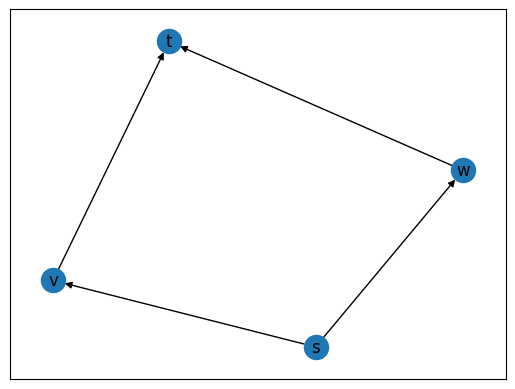

In [27]:
braess_before()

{'id': '9c0fb1f3-5ead-4efb-81fe-4e010315be27', 'x': -415, 'y': 37.125, 'label': 's'}
{'id': 'c5099898-39d5-4178-a488-6dcdda311088', 'x': -150, 'y': 54.125, 'label': 't'}
{'id': '1456ceaa-39da-421d-9eef-ebd1c0975100', 'x': -257.277587890625, 'y': -58.375, 'label': 'v'}
{'id': 'e365c756-905d-42b6-ad8a-f038f89de2aa', 'x': -9.11470281018785, 'y': 117.9947018257335, 'label': 'w'}
{('s', 'v'): <function <lambda> at 0x10a602700>, ('v', 't'): <function <lambda> at 0x10a577790>, ('s', 'w'): <function <lambda> at 0x10a577670>, ('w', 't'): <function <lambda> at 0x10a577ee0>}
old, new 0 0
All paths:  [[['s', 'v', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'w', 't']]]
Equilibrium flows:  (1, 0)
Minimum total latency:  6


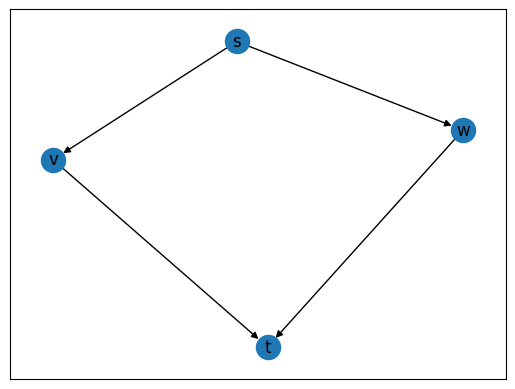

In [32]:
braess_before_2()

In [14]:
def braess_paradox_example():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, equil_flows, best_flow, min_total_latency = simulate_atomic(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Optimal flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

In [33]:
def braess_paradox_example_2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, equil_flows, min_total_latency = simulate_atomic_best_response(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Minimum total latency: ', min_total_latency)

In [59]:
def braess_paradox_example_3():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance_2('graph_examples/braess_paradox.txt')
    paths, equil_flows, min_total_latency = simulate_atomic_best_response_with_taxes(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Minimum total latency: ', min_total_latency)

{'id': '9c0fb1f3-5ead-4efb-81fe-4e010315be27', 'x': -415, 'y': 37.125, 'label': 's'}
{'id': 'c5099898-39d5-4178-a488-6dcdda311088', 'x': -150, 'y': 54.125, 'label': 't'}
{'id': '1456ceaa-39da-421d-9eef-ebd1c0975100', 'x': -257.277587890625, 'y': -58.375, 'label': 'v'}
{'id': 'e365c756-905d-42b6-ad8a-f038f89de2aa', 'x': -9.11470281018785, 'y': 117.9947018257335, 'label': 'w'}
{('s', 'v'): <function <lambda> at 0x10a602700>, ('v', 't'): <function <lambda> at 0x10a577820>, ('s', 'w'): <function <lambda> at 0x10a539700>, ('w', 't'): <function <lambda> at 0x10a74cdc0>, ('v', 'w'): <function <lambda> at 0x10a74cd30>}
old, new 0 0
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Equilibrium flows:  (1, 0)
Minimum total latency:  6


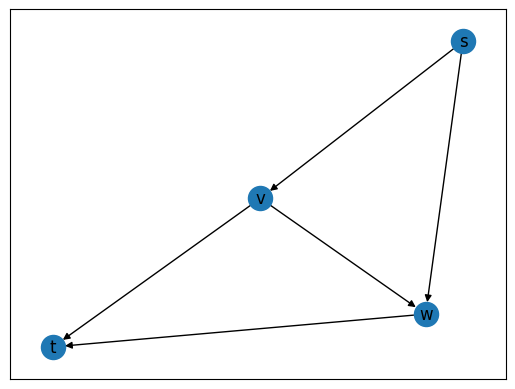

In [34]:
braess_paradox_example_2()

{'id': '9c0fb1f3-5ead-4efb-81fe-4e010315be27', 'x': -415, 'y': 37.125, 'label': 's'}
{'id': 'c5099898-39d5-4178-a488-6dcdda311088', 'x': -150, 'y': 54.125, 'label': 't'}
{'id': '1456ceaa-39da-421d-9eef-ebd1c0975100', 'x': -257.277587890625, 'y': -58.375, 'label': 'v'}
{'id': 'e365c756-905d-42b6-ad8a-f038f89de2aa', 'x': -9.11470281018785, 'y': 117.9947018257335, 'label': 'w'}
Original expression: x
Derivative: 1
Original expression: 2
Derivative: 0
Original expression: 2
Derivative: 0
Original expression: x
Derivative: 1
Original expression: 0
Derivative: 0
{('s', 'v'): (<function <lambda> at 0x10a602700>, <function _lambdifygenerated at 0x10bd91b80>), ('v', 't'): (<function <lambda> at 0x10c405280>, <function _lambdifygenerated at 0x10c46bca0>), ('s', 'w'): (<function <lambda> at 0x10c46bdc0>, <function _lambdifygenerated at 0x10c46bee0>), ('w', 't'): (<function <lambda> at 0x10c46bf70>, <function _lambdifygenerated at 0x10c4a3160>), ('v', 'w'): (<function <lambda> at 0x10c4a3310>, <fu

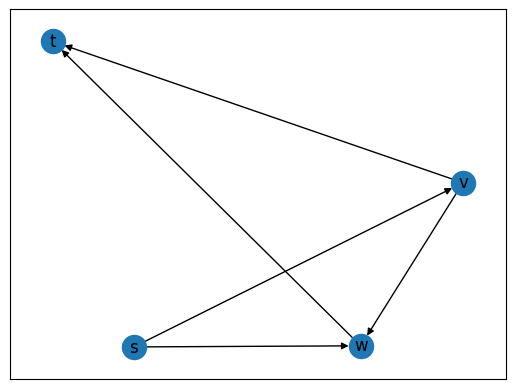

In [60]:
braess_paradox_example_3()

{'id': '9c0fb1f3-5ead-4efb-81fe-4e010315be27', 'x': -415, 'y': 37.125, 'label': 's'}
{'id': 'c5099898-39d5-4178-a488-6dcdda311088', 'x': -150, 'y': 54.125, 'label': 't'}
{'id': '1456ceaa-39da-421d-9eef-ebd1c0975100', 'x': -257.277587890625, 'y': -58.375, 'label': 'v'}
{'id': 'e365c756-905d-42b6-ad8a-f038f89de2aa', 'x': -9.11470281018785, 'y': 117.9947018257335, 'label': 'w'}
{('s', 'v'): <function <lambda> at 0x10942d670>, ('v', 't'): <function <lambda> at 0x10a577820>, ('s', 'w'): <function <lambda> at 0x10a577ee0>, ('w', 't'): <function <lambda> at 0x10a577670>, ('v', 'w'): <function <lambda> at 0x10a3eb5e0>}
[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]
[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]
******** (0, 0) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 't']
{('s', 'v'): 2, ('v', 't'): 2}
8
******** (0, 1) ********
player 0: path ['s', 'v', 't']
player 1: path ['s', 'v', 'w', 't']
{('s', 'v'): 2, ('v', 't'): 1, ('v', 'w'): 1, ('w', 't'

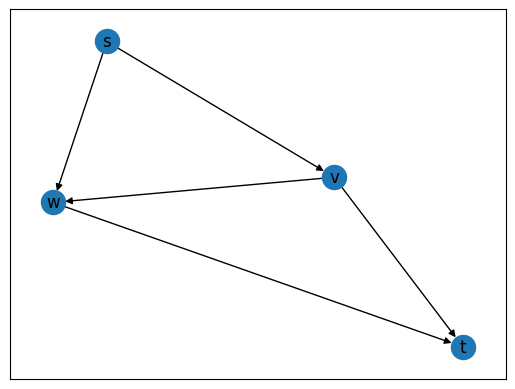

In [35]:
braess_paradox_example()

In [17]:
def AAE_example():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, equil_flows, best_flow, min_total_latency = simulate_atomic(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Optimal flow: ', best_flow)
    print('Minimum total latency: ', min_total_latency)

{'id': 'a1306657-3e3e-49d7-9710-716925d84fc9', 'x': -229, 'y': -63.875, 'label': 'u'}
{'id': '891c4019-a6b0-464d-87bf-7115dffc9c26', 'x': 13, 'y': -55.875, 'label': 'v'}
{'id': 'b0c34aba-642c-4650-a720-78f44616481f', 'x': -123.196533203125, 'y': 55.125, 'label': 'w'}
{('u', 'v'): <function <lambda> at 0x10a5c4c10>, ('v', 'u'): <function <lambda> at 0x10a5c4ca0>, ('v', 'w'): <function <lambda> at 0x10a5c4af0>, ('w', 'v'): <function <lambda> at 0x10a5c4e50>, ('u', 'w'): <function <lambda> at 0x10a5c4ee0>, ('w', 'u'): <function <lambda> at 0x10a5c4f70>}
[['u', 'v'], ['u', 'w', 'v']]
[['u', 'v', 'w'], ['u', 'w']]
[['v', 'u', 'w'], ['v', 'w']]
[['w', 'v'], ['w', 'u', 'v']]
******** (0, 0, 0, 0) ********
player 0: path ['u', 'v']
player 1: path ['u', 'v', 'w']
player 2: path ['v', 'u', 'w']
player 3: path ['w', 'v']
{('u', 'v'): 2, ('v', 'w'): 1, ('v', 'u'): 1, ('u', 'w'): 1, ('w', 'v'): 1}
7
******** (0, 0, 0, 1) ********
player 0: path ['u', 'v']
player 1: path ['u', 'v', 'w']
player 2: pa

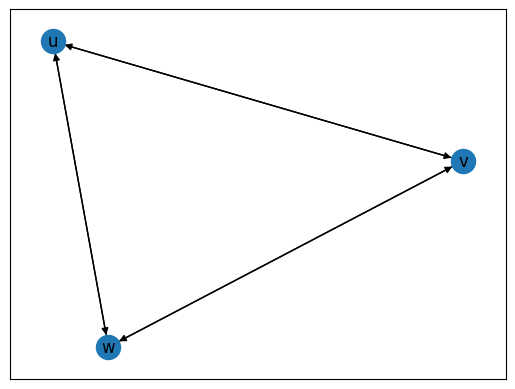

In [18]:
AAE_example()

In [36]:
def AAE_example_2():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, equil_flows, min_total_latency = simulate_atomic_best_response(G, source_sink_pairs, demands, latency_functions)
    print('All paths: ', paths)
    print('Equilibrium flows: ', equil_flows)
    print('Minimum total latency: ', min_total_latency)

{'id': 'a1306657-3e3e-49d7-9710-716925d84fc9', 'x': -229, 'y': -63.875, 'label': 'u'}
{'id': '891c4019-a6b0-464d-87bf-7115dffc9c26', 'x': 13, 'y': -55.875, 'label': 'v'}
{'id': 'b0c34aba-642c-4650-a720-78f44616481f', 'x': -123.196533203125, 'y': 55.125, 'label': 'w'}
{('u', 'v'): <function <lambda> at 0x10a77faf0>, ('v', 'u'): <function <lambda> at 0x10a77f550>, ('v', 'w'): <function <lambda> at 0x10a77f4c0>, ('w', 'v'): <function <lambda> at 0x10a77f790>, ('u', 'w'): <function <lambda> at 0x10a77f8b0>, ('w', 'u'): <function <lambda> at 0x10a77fa60>}
old, new 0 0
old, new 0 0
All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
Equilibrium flows:  (0, 1, 1, 0)
Minimum total latency:  4


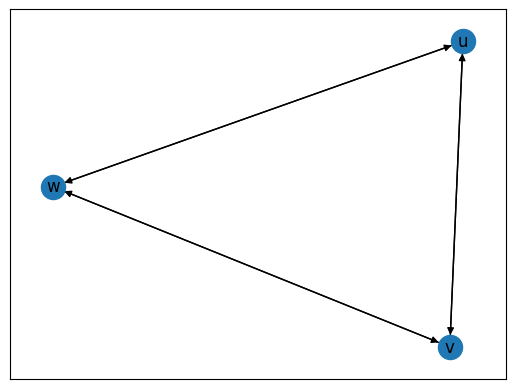

In [37]:
AAE_example_2()